In [1]:
# Import necessary libraries
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, RepeatVector
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
import cv2
import matplotlib.pyplot as plt
import urllib.request


In [2]:
"""
# Download dataset (modify or comment these lines as needed)
urllib.request.urlretrieve('https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip', 'dataset.zip')
urllib.request.urlretrieve('https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip', 'captions.zip')
"""

"\n# Download dataset (modify or comment these lines as needed)\nurllib.request.urlretrieve('https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip', 'dataset.zip')\nurllib.request.urlretrieve('https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip', 'captions.zip')\n"

In [3]:

# Function to load captions and filter by image IDs
def load_captions(caption_file, image_id_file):
    captions = {}
    with open(caption_file, 'r') as f:
        for line in f:
            tokens = line.strip().split('\t')
            if len(tokens) == 2:
                image_id, caption = tokens[0], tokens[1]
                image_id = image_id.split('#')[0]  # Remove the #<number> suffix
                if image_id not in captions:
                    captions[image_id] = []
                captions[image_id].append(caption)

    image_ids = set()
    with open(image_id_file, 'r') as f:
        for line in f:
            image_ids.add(line.strip())

    filtered_captions = {image_id: captions[image_id] for image_id in image_ids if image_id in captions}
    return filtered_captions

# Load captions for training, validation, and testing
caption_file = 'Flickr8k_text/Flickr8k.token.txt'
train_image_ids_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'
val_image_ids_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
test_image_ids_file = 'Flickr8k_text/Flickr_8k.testImages.txt'


In [4]:
import ssl
import certifi

ssl._create_default_https_context = ssl._create_unverified_context


In [5]:

train_captions = load_captions(caption_file, train_image_ids_file)
val_captions = load_captions(caption_file, val_image_ids_file)
test_captions = load_captions(caption_file, test_image_ids_file)

# Display the number of images in each set
print("Number of training images:", len(train_captions))
print("Number of validation images:", len(val_captions))
print("Number of test images:", len(test_captions))


Number of training images: 6000
Number of validation images: 1000
Number of test images: 1000


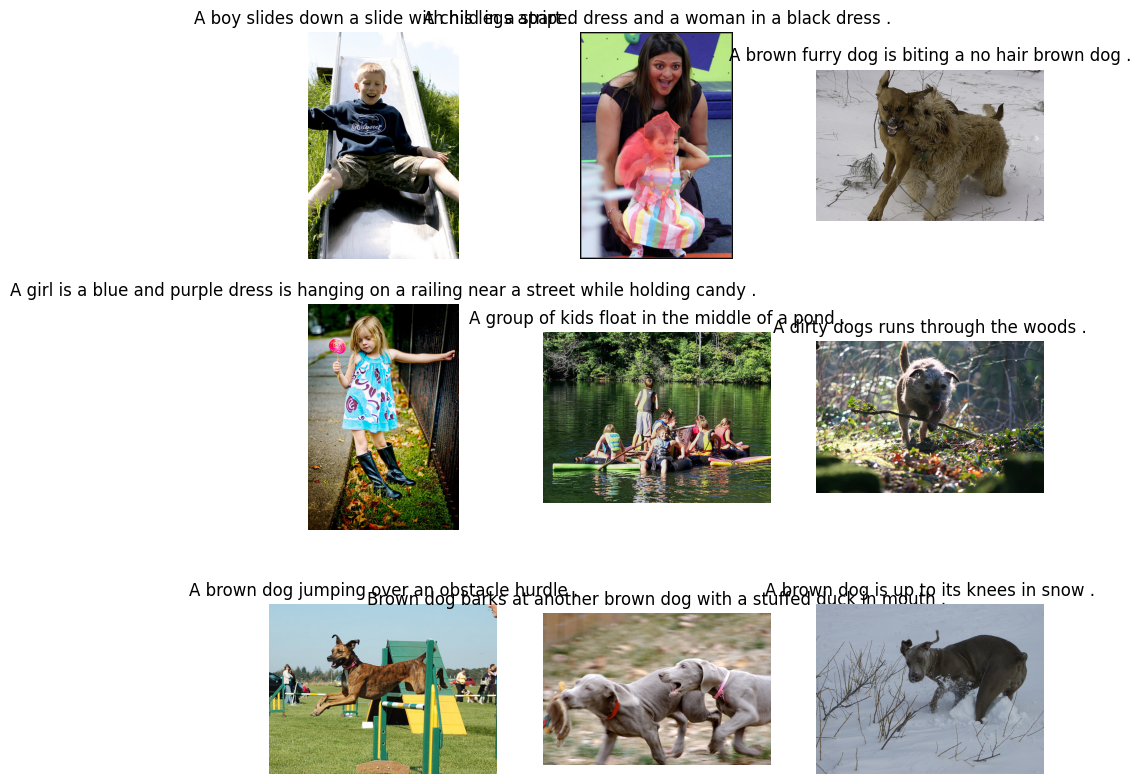

In [6]:

# Load VGG16 model
cnn_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
cnn_model = Model(inputs=cnn_model.inputs, outputs=cnn_model.layers[-1].output)

# Function to extract features from an image
def extract_features(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    features = cnn_model.predict(image)
    return features

# Display a few sample images and their captions
fig = plt.figure(figsize=(10, 10))
sample_image_paths = list(train_captions.keys())[:9]
for i, image_id in enumerate(sample_image_paths):
    image_path = os.path.join('Flicker8k_Dataset', image_id)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("\n".join(train_captions[image_id][:1]))  # Display the first caption
plt.show()


In [7]:

# Example model building (use appropriate data preparation and input)
def build_captioning_model(vocab_size, max_caption_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=256, input_length=max_caption_length))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

# Define vocab size and max caption length (these should be determined during data preprocessing)
vocab_size = 1000
max_caption_length = 10
captioning_model = build_captioning_model(vocab_size, max_caption_length)
captioning_model.summary()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:

# Install NLTK for BLEU score evaluation
!pip3 install nltk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.6/284.6 kB 25.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


In [11]:
from nltk.translate.bleu_score import sentence_bleu

# Function for evaluating BLEU score
def evaluate_bleu(reference, candidate):
    reference = [reference]  # NLTK BLEU expects a list of references
    return sentence_bleu(reference, candidate)

# Test BLEU score evaluation
dummy_generated_caption = ["this", "is", "a", "generated", "caption"]
reference_captions = ["a sample caption of an image".split()]  # Example reference
bleu_score = evaluate_bleu(reference_captions[0], dummy_generated_caption)
print("BLEU score for the generated caption:", bleu_score)


BLEU score for the generated caption: 1.1862177682648818e-231


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-